# Problem Statement 4: Creating a Game of Snake Using RL

![image.png](attachment:image.png)

### Question 1:

What is the effect of change in deep neural network model and its hyper parameters for agent training, for example, will adding more dense layers have any effect on snake’s learnability? Write your observation.

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

#Import libraries
from google.colab import drive 


#get drive
drive.mount('/content/drive')

!pip install pygame

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from operator import add
from random import randint


import pygame
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import json
import pandas as pd
pygame.font.init()

import os
os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
global CONFIG_TXT
 
CONFIG_TXT = r'config.txt'

In [ ]:
#Q-logic
class SnakeAgent(object):

    def __init__(self):
        self.config = json.loads(open('/content/drive/My Drive/Data_Science/All Modules/6 AI and Deep Learning/4 Building Games using RL/config.txt').read())
        self.reward = 0
        self.gamma = 0.9
        self.dataframe = pd.DataFrame()
        self.short_memory = np.array([])
        self.agent_target = 1
        self.agent_predict = 0
        self.learning_rate = 0.00005  # 0.00005 # 0.0000005
        if eval(self.config['use_pre_trained_model']):
            self.model = self.deep_network(self.config['pre_trained_model_name'])
        else:
            self.model = self.deep_network()
        self.epsilon = 0
        self.actual = []
        self.memory = []

    def get_game_state(self, game, player, food):

        movement = int(self.config['movement'])
        state = [
            (player.snake_x_change == movement and player.snake_y_change == 0 and ((list(map(add, player.snake_position[-1], [movement, 0])) in player.snake_position) or
            player.snake_position[-1][0] + movement >= (game.game_width - movement))) or (player.snake_x_change == -movement and player.snake_y_change == 0 and ((list(map(add, player.snake_position[-1], [-movement, 0])) in player.snake_position) or
            player.snake_position[-1][0] - movement < movement)) or (player.snake_x_change == 0 and player.snake_y_change == -movement and ((list(map(add, player.snake_position[-1], [0, -movement])) in player.snake_position) or
            player.snake_position[-1][-1] - movement < movement)) or (player.snake_x_change == 0 and player.snake_y_change == movement and ((list(map(add, player.snake_position[-1], [0, movement])) in player.snake_position) or
            player.snake_position[-1][-1] + movement >= (game.game_height-movement))),

            (player.snake_x_change == 0 and player.snake_y_change == -movement and ((list(map(add,player.snake_position[-1],[movement, 0])) in player.snake_position) or
            player.snake_position[ -1][0] + movement > (game.game_width-movement))) or (player.snake_x_change == 0 and player.snake_y_change == movement and ((list(map(add,player.snake_position[-1],
            [-movement,0])) in player.snake_position) or player.snake_position[-1][0] - movement < movement)) or (player.snake_x_change == -movement and player.snake_y_change == 0 and ((list(map(
            add,player.snake_position[-1],[0,-movement])) in player.snake_position) or player.snake_position[-1][-1] - movement < movement)) or (player.snake_x_change == movement and player.snake_y_change == 0 and (
            (list(map(add,player.snake_position[-1],[0,movement])) in player.snake_position) or player.snake_position[-1][
             -1] + movement >= (game.game_height-movement))),

             (player.snake_x_change == 0 and player.snake_y_change == movement and ((list(map(add,player.snake_position[-1],[movement,0])) in player.snake_position) or
             player.snake_position[-1][0] + movement > (game.game_width-movement))) or (player.snake_x_change == 0 and player.snake_y_change == -movement and ((list(map(
             add, player.snake_position[-1],[-movement,0])) in player.snake_position) or player.snake_position[-1][0] - movement < movement)) or (player.snake_x_change == movement and player.snake_y_change == 0 and (
            (list(map(add,player.snake_position[-1],[0,-movement])) in player.snake_position) or player.snake_position[-1][-1] - movement < movement)) or (
            player.snake_x_change == -movement and player.snake_y_change == 0 and ((list(map(add,player.snake_position[-1],[0,movement])) in player.snake_position) or
            player.snake_position[-1][-1] + movement >= (game.game_height-movement))),


            player.snake_x_change == -movement,
            player.snake_x_change == movement,
            player.snake_y_change == -movement,
            player.snake_y_change == movement,
            food.x_dimension_food < player.snake_x,
            food.x_dimension_food > player.snake_x,
            food.y_dimension_food < player.snake_y,
            food.y_dimension_food > player.snake_y
            ]

        for i in range(len(state)):
            if state[i]:
                state[i]=1
            else:
                state[i]=0
        #print(np.asarray(state))
        return np.asarray(state)

    def reward_init(self, player, crash):
        self.reward = 0
        if crash:
            #self.reward = -15
            self.reward = -50
            return self.reward
        if player.snake_has_eaten:
            #self.reward = 20
            self.reward = 5
        return self.reward

    def deep_network(self, weights=None):
        model = tf.keras.Sequential()
        for numberofLayer in range(int(self.config['TotalDenseLayer'])):
            model.add(tf.keras.layers.Dense(units=int(self.config['Dense_Layer_Neuron']), activation=tf.keras.activations.relu, input_dim=11))
            model.add(tf.keras.layers.Dropout(float(self.config['Dropout'])))

        model.add(tf.keras.layers.Dense(units=3, activation=tf.keras.activations.softmax))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam((self.learning_rate)), metrics=['accuracy'])

        if weights:
            model.load_weights(weights)
        model.summary()
        return model

    def remember_state(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay_reset_new(self, memory):
        if len(memory) > 1000:
            minibatch = random.sample(memory, 1000)
        else:
            minibatch = memory
        #print(minibatch)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(np.array([next_state]))[0])
            target_f = self.model.predict(np.array([state]))
            target_f[0][np.argmax(action)] = target
            self.model.fit(np.array([state]), target_f, epochs=10, verbose=0)


    def minibatch_train(self, state, action, reward, next_state, done):

        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state.reshape((1, 11)))[0])
        target_f = self.model.predict(state.reshape((1, 11)))
        target_f[0][np.argmax(action)] = target
        self.model.fit(state.reshape((1, 11)), target_f, epochs=10, verbose=0)

In [ ]:
# GameFunctions
def eat(player, food, game):
    #print('food.food_pos     : ', (food.x_dimension_food, food.y_dimension_food))
    #print('player.snake_pos  : ', (player.snake_x, player.snake_y) )
    
    if player.snake_x == food.x_dimension_food and player.snake_y == food.y_dimension_food:
        food.position_food(game, player)
        player.snake_has_eaten = True
        game.score = game.score + 1
        #print('score : ', game.score)


def get_record(score, record):
    if score >= record:
        return score
    else:
        return record


def display_ui(game, score, record):
    myfont = pygame.font.SysFont('Segoe UI', 20)
    myfont_bold = pygame.font.SysFont('Segoe UI', 20, True)
    text_score = myfont.render('SCORE: ', True, (0, 0, 0))
    text_score_number = myfont.render(str(score), True, (0, 0, 0))
    text_highest = myfont.render('HIGHEST SCORE: ', True, (0, 0, 0))
    text_highest_number = myfont_bold.render(str(record), True, (0, 0, 0))
    game.gameDisplay.blit(text_score, (45, 350))
    game.gameDisplay.blit(text_score_number, (120, 350))
    game.gameDisplay.blit(text_highest, (190, 350))
    game.gameDisplay.blit(text_highest_number, (340, 350))
    game.gameDisplay.blit(game.bg, (10, 10))


def display(player, food, game, record):
    game.gameDisplay.fill((255, 255, 255))
    display_ui(game, game.score, record)
    player.display_player(player.snake_position[-1][0], player.snake_position[-1][1], player.snake_food, game)
    food.display_food(food.x_dimension_food, food.y_dimension_food, game)


def update_screen():
    pygame.display.update()

def close_screen():
    pygame.display.quit()
    pygame.quit()


def initialize_game(player, game, food, agent):
    state_init1 = agent.get_game_state(game, player, food)
    action = [1, 0, 0]
    player.do_move(action, player.snake_x, player.snake_y, game, food, agent)
    state_init2 = agent.get_game_state(game, player, food)
    reward1 = agent.reward_init(player, game.crash)
    print('Reward @ initialize: ', reward1)
    agent.remember_state(state_init1, action, reward1, state_init2, game.crash)
    agent.replay_reset_new(agent.memory)


def plot_seaborn(array_counter, array_score):
    sns.set(color_codes=True)
    ax = sns.regplot(np.array([array_counter])[0], np.array([array_score])[0], color="b", x_jitter=.1, line_kws={'color':'green'})
    ax.set(xlabel='games', ylabel='score')
    plt.show()

In [ ]:
#player class
class PlayerClass(object):

    def __init__(self, game):
        self.config = json.loads(open('/content/drive/My Drive/Data_Science/All Modules/6 AI and Deep Learning/4 Building Games using RL/config.txt').read())
        x = 0.45 * game.game_width
        y = 0.5 * game.game_height
        self.snake_x = x - x % 20
        self.snake_y = y - y % 20
        self.snake_position = []
        self.snake_position.append([self.snake_x, self.snake_y])
        self.snake_food = 1
        self.snake_has_eaten = False
        self.snake_body_image = pygame.image.load('/content/drive/My Drive/Data_Science/All Modules/6 AI and Deep Learning/4 Building Games using RL/img/snake_body.png')
        self.snake_x_change = int(self.config['movement'])
        self.snake_y_change = 0
        #print('init: ', self.snake_x, self.snake_y)

    def update_position(self, x, y):
        if self.snake_position[-1][0] != x or self.snake_position[-1][1] != y:
            if self.snake_food > 1:
                for i in range(0, self.snake_food - 1):
                    self.snake_position[i][0], self.snake_position[i][1] = self.snake_position[i + 1]
            self.snake_position[-1][0] = x
            self.snake_position[-1][1] = y

    def do_move(self, move, x, y, game, food,agent):
        move_array = [self.snake_x_change, self.snake_y_change]

        if self.snake_has_eaten:

            self.snake_position.append([self.snake_x, self.snake_x])
            self.snake_has_eaten = False
            self.snake_food = self.snake_food + 1
        if np.array_equal(move ,[1, 0, 0]):
            move_array = self.snake_x_change, self.snake_y_change
        elif np.array_equal(move,[0, 1, 0]) and self.snake_y_change == 0:
            move_array = [0, self.snake_x_change]
        elif np.array_equal(move,[0, 1, 0]) and self.snake_x_change == 0:
            move_array = [-self.snake_y_change, 0]
        elif np.array_equal(move, [0, 0, 1]) and self.snake_y_change == 0:
            move_array = [0, -self.snake_x_change]
        elif np.array_equal(move,[0, 0, 1]) and self.snake_x_change == 0:
            move_array = [self.snake_y_change, 0]
        self.snake_x_change, self.snake_y_change = move_array
        self.snake_x = x + self.snake_x_change
        self.snake_y = y + self.snake_y_change
        #print(self.snake_x, self.snake_y)
                
        if self.snake_x < 10 or self.snake_x > game.game_width or self.snake_y < 10 or self.snake_y > game.game_height-10 or [self.snake_x, self.snake_y] in self.snake_position:
        #    print(self.snake_x, self.snake_y)
            game.crash = True
        eat(self, food, game)

        self.update_position(self.snake_x, self.snake_y)

    def display_player(self, x, y, food, game):
        self.snake_position[-1][0] = x
        self.snake_position[-1][1] = y

        if game.crash == False:
            for i in range(food):
                x_temp, y_temp = self.snake_position[len(self.snake_position) - 1 - i]
                game.gameDisplay.blit(self.snake_body_image, (x_temp, y_temp))

            update_screen()
        else:
            pygame.time.wait(50)

In [ ]:
#Food Class
class FoodClass(object):

    def __init__(self):
        self.config = json.loads(open('/content/drive/My Drive/Data_Science/All Modules/6 AI and Deep Learning/4 Building Games using RL/config.txt').read())
        self.image = pygame.image.load('/content/drive/My Drive/Data_Science/All Modules/6 AI and Deep Learning/4 Building Games using RL/img/food_burger.png')
        self.x_dimension_food = int(self.config['x_dimension_food'])
        self.y_dimension_food = int(self.config['y_dimension_food'])

    def position_food(self, game, player):
        x_rand = randint(25, game.game_width - 40)
        self.x_dimension_food = x_rand - x_rand % 20
        y_rand = randint(25, game.game_height - 40)
        self.y_dimension_food = y_rand - y_rand % 25
        #print('food dim : ', self.x_dimension_food, self.y_dimension_food)
        if [self.x_dimension_food, self.y_dimension_food] not in player.snake_position:
            return self.x_dimension_food, self.y_dimension_food
        else:
            self.position_food(game,player)

    def display_food(self, x, y, game):
        game.gameDisplay.blit(self.image, (x, y))
        update_screen()

In [ ]:
# game class
class Game_Logic_Core:

    def __init__(self, game_width, game_height):
        pygame.display.set_caption('Edureka Assignment 5.2 Snake RL')
        self.game_width = game_width
        self.game_height = game_height
        self.gameDisplay = pygame.display.set_mode((game_width, game_height+60))
        self.bg = pygame.image.load("/content/drive/My Drive/Data_Science/All Modules/6 AI and Deep Learning/4 Building Games using RL/img/background_white.png")
        self.crash = False
        self.player = PlayerClass(self)
        self.food = FoodClass()
        self.score = 0

In [ ]:
def main(config):
    pygame.init()
    agent = SnakeAgent()   # #Q-logic
    game_counter = 0
    score_plot = []
    counter_plot =[]
    record = 0
    while game_counter < int(config['total_iteration']):
        #for event in pygame.event.get():
        #    if event.type == pygame.QUIT:
        #        close_screen()
        
        Game_Logic_Core_Object = Game_Logic_Core(eval(config['game_grid'])[0], eval(config['game_grid'])[1]) # game class
        player_core = Game_Logic_Core_Object.player    #player class
        food = Game_Logic_Core_Object.food             #food class
        print ("THE DQN is learning how to play SNAKE .......")
        initialize_game(player_core, Game_Logic_Core_Object, food, agent)  # GameFunctions
        if display_option:
            display(player_core, food, Game_Logic_Core_Object, record)  # GameFunctions

        while not Game_Logic_Core_Object.crash:
            agent.epsilon = int(config['epsilon']) - game_counter
            state_old = agent.get_game_state(Game_Logic_Core_Object, player_core, food)
            #print('state_old : ', state_old)
            
            if randint(0, 150) < agent.epsilon:
                final_move = tf.keras.utils.to_categorical(randint(0, 2), num_classes=3)
            else:
                prediction = agent.model.predict(state_old.reshape((1,11)))
                final_move = tf.keras.utils.to_categorical(np.argmax(prediction[0]), num_classes=3)

            player_core.do_move(final_move, player_core.snake_x, player_core.snake_y, Game_Logic_Core_Object, food, agent)
            state_new = agent.get_game_state(Game_Logic_Core_Object, player_core, food)

            reward = agent.reward_init(player_core, Game_Logic_Core_Object.crash)
            agent.minibatch_train(state_old, final_move, reward, state_new, Game_Logic_Core_Object.crash)

            agent.remember_state(state_old, final_move, reward, state_new, Game_Logic_Core_Object.crash)
            record = get_record(Game_Logic_Core_Object.score, record)
            if display_option:
                display(player_core, food, Game_Logic_Core_Object, record)
                pygame.time.wait(speed)

        agent.replay_reset_new(agent.memory)
        game_counter += 1
        if eval(config['print_learning_scores']):
            print('Learning Stage -> ', game_counter, '      Max Score Achived:', Game_Logic_Core_Object.score)
        score_plot.append(Game_Logic_Core_Object.score)
        counter_plot.append(game_counter)
    if eval(config['save_weights']):
        agent.model.save_weights(config['model_name_aftertrain'])
    if eval(config['learning_curve']):
        plot_seaborn(counter_plot, score_plot)
        
    close_screen()

In [ ]:
# edit configurations, if required
config = json.loads(open('/content/drive/My Drive/Data_Science/All Modules/6 AI and Deep Learning/4 Building Games using RL/config.txt').read())
display_option = eval(config['display_option'])
speed = int(config['game_speed'])

print(config)

{'display_option': 'True', 'game_speed': 0, 'save_weights': 'True', 'model_name_aftertrain': 'Model_run_26feb_no.hdf5', 'total_iteration': 2, 'game_grid': '[440, 440]', 'epsilon': 80, 'learning_curve': 'True', 'print_learning_scores': 'True', 'use_pre_trained_model': 'False', 'pre_trained_model_name': 'weights.hdf5', 'reward': 10, 'food_image': 'img/food_burger.png', 'x_dimension_food': 240, 'y_dimension_food': 200, 'TotalDenseLayer': 2, 'Dense_Layer_Neuron': 150, 'Dropout': 0.3, 'movement': 30, 'snake_body_image': 'img/snake_body_black_small.png'}


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 150)               1800      
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 453       
Total params: 24,903
Trainable params: 24,903
Non-trainable params: 0
_________________________________________________________________
THE DQN is learning how to play SNAKE .......
Reward @ initialize:  0
Learning Stage ->  1       Max Score Achived: 0


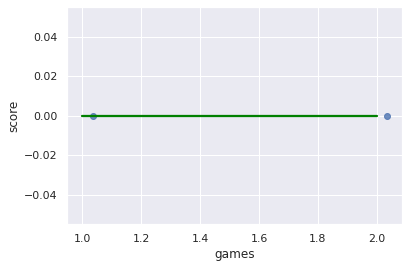

In [ ]:
# calling main function
#  "TotalDenseLayer": 20,
#  "Dense_Layer_Neuron": 200,

main(config)

{'display_option': 'True', 'game_speed': 0, 'save_weights': 'True', 'model_name_aftertrain': 'Model_run_26feb_no.hdf5', 'total_iteration': 2, 'game_grid': '[440, 440]', 'epsilon': 80, 'learning_curve': 'True', 'print_learning_scores': 'True', 'use_pre_trained_model': 'False', 'pre_trained_model_name': 'weights.hdf5', 'reward': 10, 'food_image': 'img/food_burger.png', 'x_dimension_food': 240, 'y_dimension_food': 200, 'TotalDenseLayer': 2, 'Dense_Layer_Neuron': 150, 'Dropout': 0.3, 'movement': 30, 'snake_body_image': 'img/snake_body_black_small.png'}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 150)               1800      
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_4 (Dense)            

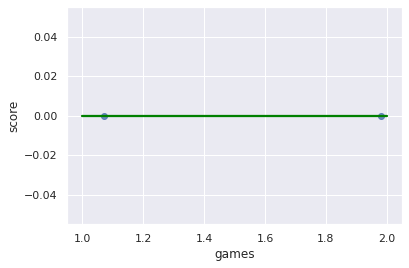

In [ ]:
# hyper parameter tuning - adding more dense layers to check model performance
#   "TotalDenseLayer": 50,
#  "Dense_Layer_Neuron": 500,
# "total_iteration" : 20
# edit configurations, if required

config = json.loads(open('/content/drive/My Drive/Data_Science/All Modules/6 AI and Deep Learning/4 Building Games using RL/config.txt').read())
display_option = eval(config['display_option'])
speed = int(config['game_speed'])

print(config)

main(config)

**Answer:**

The effect of adding more layers help in training deep models more efficiently and increase snake's learnability. 

### Question 2:

What will happen if we make the positive reward as +5 and negative reward as -50. Does it change the snake’s performance? Change the reward in Q_logic -> reward_init function and note down your observation.

{'display_option': 'True', 'game_speed': 0, 'save_weights': 'True', 'model_name_aftertrain': 'Model_run_26feb_no.hdf5', 'total_iteration': 2, 'game_grid': '[440, 440]', 'epsilon': 80, 'learning_curve': 'True', 'print_learning_scores': 'True', 'use_pre_trained_model': 'False', 'pre_trained_model_name': 'weights.hdf5', 'reward': 10, 'food_image': 'img/food_burger.png', 'x_dimension_food': 240, 'y_dimension_food': 200, 'TotalDenseLayer': 2, 'Dense_Layer_Neuron': 150, 'Dropout': 0.3, 'movement': 30, 'snake_body_image': 'img/snake_body_black_small.png'}
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 150)               1800      
_________________________________________________________________
dropout_4 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_7 (Dense)            

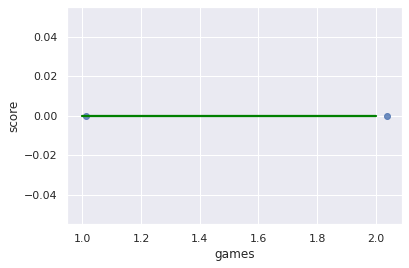

In [ ]:
# changin the reward points. Rest all remains the same with layers = 50 & neurons /layer = 500
config = json.loads(open('/content/drive/My Drive/Data_Science/All Modules/6 AI and Deep Learning/4 Building Games using RL/config.txt').read())
display_option = eval(config['display_option'])
speed = int(config['game_speed'])

print(config)

main(config)

{'display_option': 'True', 'game_speed': 0, 'save_weights': 'True', 'model_name_aftertrain': 'Model_run_26feb_no.hdf5', 'total_iteration': 2, 'game_grid': '[440, 440]', 'epsilon': 80, 'learning_curve': 'True', 'print_learning_scores': 'True', 'use_pre_trained_model': 'False', 'pre_trained_model_name': 'weights.hdf5', 'reward': 10, 'food_image': 'img/food_burger.png', 'x_dimension_food': 240, 'y_dimension_food': 200, 'TotalDenseLayer': 2, 'Dense_Layer_Neuron': 150, 'Dropout': 0.3, 'movement': 30, 'snake_body_image': 'img/snake_body_black_small.png'}
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 150)               1800      
_________________________________________________________________
dropout_8 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_13 (Dense)           

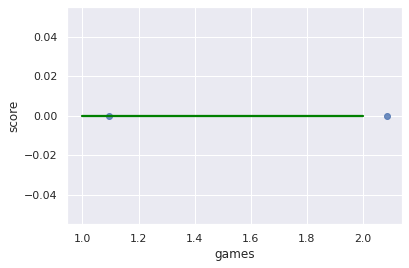

In [ ]:
# Model training with +ve rewards 20 & -ve reward 15 & layers= 3, & neurons per layer = 150
config = json.loads(open('/content/drive/My Drive/Data_Science/All Modules/6 AI and Deep Learning/4 Building Games using RL/config.txt').read())
display_option = eval(config['display_option'])
speed = int(config['game_speed'])

print(config)

main(config)

{'display_option': 'True', 'game_speed': 0, 'save_weights': 'True', 'model_name_aftertrain': 'Model_run_26feb_no.hdf5', 'total_iteration': 2, 'game_grid': '[440, 440]', 'epsilon': 80, 'learning_curve': 'True', 'print_learning_scores': 'True', 'use_pre_trained_model': 'False', 'pre_trained_model_name': 'weights.hdf5', 'reward': 10, 'food_image': 'img/food_burger.png', 'x_dimension_food': 240, 'y_dimension_food': 200, 'TotalDenseLayer': 2, 'Dense_Layer_Neuron': 150, 'Dropout': 0.3, 'movement': 30, 'snake_body_image': 'img/snake_body_black_small.png'}
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 150)               1800      
_________________________________________________________________
dropout_10 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_16 (Dense)           

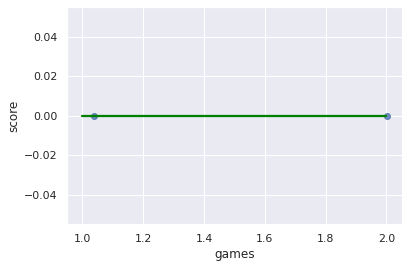

In [ ]:
# Model training with +ve rewards 5 & -ve reward 50 & layers= 3, & neurons per layer = 150
config = json.loads(open('/content/drive/My Drive/Data_Science/All Modules/6 AI and Deep Learning/4 Building Games using RL/config.txt').read())
display_option = eval(config['display_option'])
speed = int(config['game_speed'])

print(config)

main(config)

**Answer:**

Snake's performance improved when we change the reward for the snake.
